In [6]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rocketpy import Environment, SolidMotor, Rocket, Flight
from rocketpy.rocket.aero_surface.fins.trapezoidal_fins import TrapezoidalFins

from pathlib import Path
import subprocess
repo_root = Path(
    subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
)

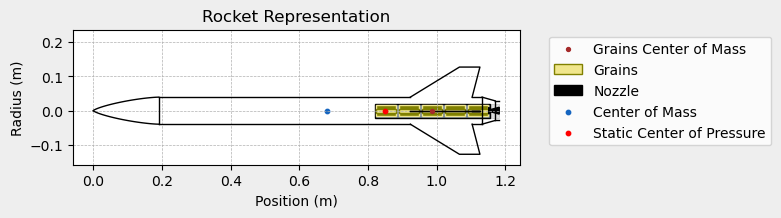


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 224.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.999 | e1: -0.044 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.137 c


Surface Wind Conditions

Frontal Surface Wind Speed: 2.19 m/s
Lateral Surface Wind Speed: -0.91 m/s


Launch Rail

Launch Rail Length: 5.2 m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.333 s
Rail Departure Velocity: 32.299 m/s
Rail Departure Stability Margin: 2.229 c
Rail Departure Angle of Attack: 4.353°
Rail Departure Thrust-Weight Ratio: 11.060
Rail Departure Reynolds Number: 1.778e+05


Burn out State

Burn out time: 1.971 s
Altitude at burn out: 408.121 m (ASL) | 184.123 m (AGL)
Rocket speed at burn out: 166.479 m/s
Freestream velocit

/var/folders/b8/sthvbfr114z549q_mgk2bnyc0000gn/T/ipykernel_72551/2518491450.py:74: DeprecationWarning: Moved to FlightDataExporter.export_data() and will be removed in v1.12.0. Use `rocketpy.simulation.flight_data_exporter.FlightDataExporter.export_data` instead.
  test_flight.export_data(


In [7]:
# Rocket
maurice2 = Rocket(
    radius=7.87/2/100,
    mass=2328/1000,
    inertia=(0.287, 0.287, 0.0035),
    power_off_drag=0.6175,
    power_on_drag=0.633,
    center_of_mass_without_motor=59.7/100,
    coordinate_system_orientation="nose_to_tail",
)

# Motor
eng_path = repo_root / "data" / "AeroTech_HP-I280DM.eng"
motor = SolidMotor(
    thrust_source=str(eng_path),  # Or use a CSV thrust file
    dry_mass=(0.616 - 0.355),  # kg
    burn_time=1.971,  # Corrected burn time
    dry_inertia=(0.00055, 0.00055, 0.00011),  # kg·m² (approximated)
    nozzle_radius= (10 / 1000), 
    grain_number=5,
    grain_density=1800, # Fixed grain density 18 --> 1800 kg·m^3
    grain_outer_radius= 16 / 1000,  
    grain_initial_inner_radius= 6 / 1000,  
    grain_initial_height= 57 / 1000,  
    grain_separation=0.01,  
    grains_center_of_mass_position=-0.1044,  # Estimated
    center_of_dry_mass_position=-0.122,  # Estimated
    nozzle_position=-0.3,
    throat_radius= 3.5 / 1000,  
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

maurice2.add_motor(motor, position=88.2/100)

# Nose cone
nose_cone = maurice2.add_nose(
    length=19/100, kind="Von Karman", position=0
)

# Boat tail
tail = maurice2.add_tail(
    top_radius=7.87/2/100, bottom_radius=5.72/2/100, length=3.81/100, position=(117-3.81)/100
)

# Fins
fins = TrapezoidalFins(
    n=4,
    root_chord=18/100,
    tip_chord=5.97/100,
    span=8.76/100,
    rocket_radius=7.87/2/100,
    cant_angle=0.01,  # degrees
    sweep_length=14.3/100,
)

maurice2.add_surfaces(fins, (92.3)/100)

# Environment
env = Environment(latitude=41.92298772007185, longitude=-88.06013490408121, elevation=243.43)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  
env.set_atmospheric_model(type="Forecast", file="GFS")
maurice2.draw()

# Flight
test_flight = Flight(
    rocket=maurice2, environment=env, rail_length=5.2, inclination=85, heading=0
    )

test_flight.info()

# Export data
rp_path = repo_root / "data" / "rocketpy_data.csv"
test_flight.export_data(
            str(rp_path),
            "w1",
            "w2",
            "w3",
            "alpha1",
            "alpha2",
            "alpha3",
            "vx",
            "vy",
            "vz",
            "x",
            "y",
            "z",
            "e0",
            "e1",
            "e2",
            "e3",
        )

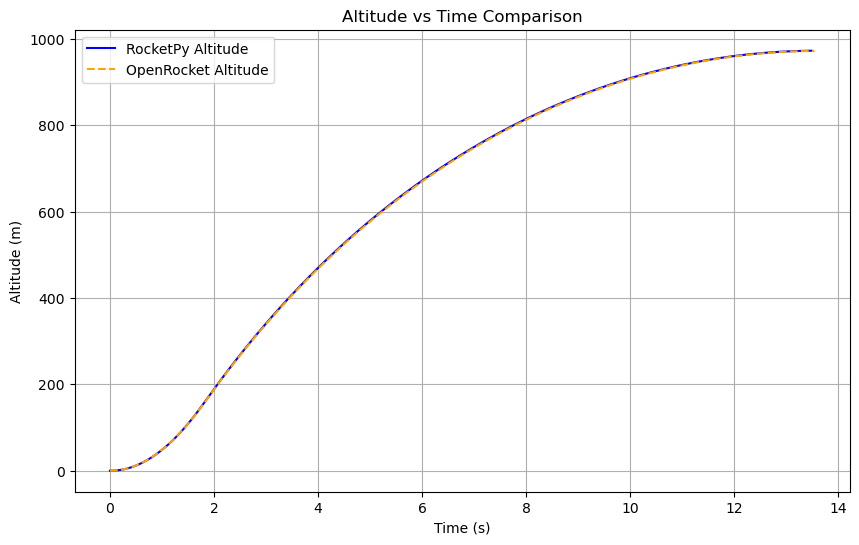

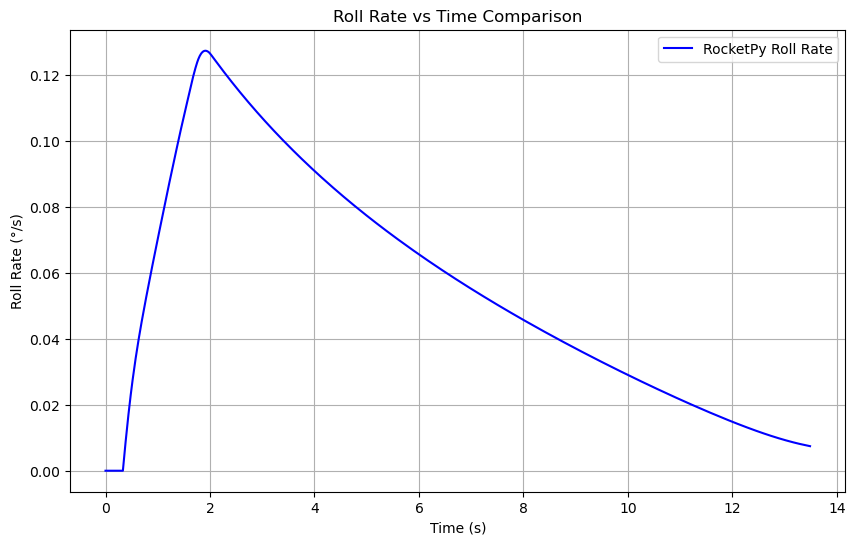

In [8]:
or_path = repo_root / "data" / "openrocket_data2.csv"
or_data = pd.read_csv(str(or_path))
rp_data = pd.read_csv(str(rp_path))

rp_mask = rp_data["# Time (s)"] <= 13.571
or_mask = or_data["# Time (s)"] <= 13.571
rp_data = rp_data[rp_mask] - rp_data[rp_mask].iloc[0]
or_data = or_data[or_mask]

def compare_or():
    """Plot comparison between RocketPy and OpenRocket simulation data for altitude and velocity over time.
    """
    plt.figure(figsize=(10,6))
    plt.plot(rp_data["# Time (s)"], rp_data[" Z (m)"], label="RocketPy Altitude", color='blue')
    plt.plot(or_data["# Time (s)"], or_data["Altitude (m)"], label="OpenRocket Altitude", color='orange', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (m)")
    plt.title("Altitude vs Time Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(rp_data["# Time (s)"], rp_data[" ω3 (rad/s)"], label="RocketPy Roll Rate", color='blue')
    # plt.plot(or_data["# Time (s)"], np.deg2rad(or_data["Roll rate (°/s)"]), label="OpenRocket Roll Rate", color='orange', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Roll Rate (°/s)")
    plt.title("Roll Rate vs Time Comparison")
    plt.legend()
    plt.grid()
    plt.show()

compare_or()